<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/6.%20CNN/SimpleCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data already downloaded.


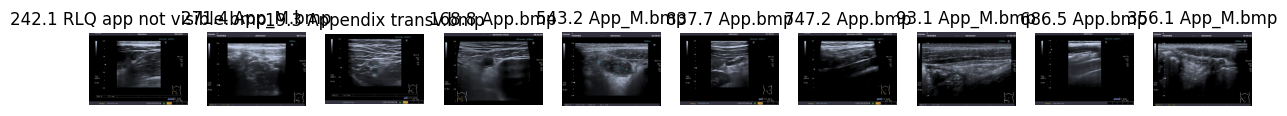

Loading and preprocessing data...
Loaded and preprocessed data with 760 entries
Processing and saving images...


Processing images: 100%|██████████| 2098/2098 [00:34<00:00, 61.10it/s]


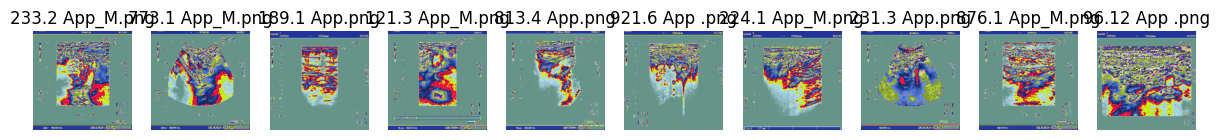

Initializing MedicalImagesDataset...
Initialized MedicalImagesDataset with 1727 images.
Dataset initialized with 1727 samples
Training set size: 1381
Validation set size: 172
Test set size: 174


Epoch 1/10 [Validation]: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]


Epoch 1/10
Train Loss: 0.5851, Train Acc: 0.7632, Train ROC AUC: 0.5491
Val Acc: 0.7558, Val ROC AUC: 0.6419


Epoch 2/10 [Validation]: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


Epoch 2/10
Train Loss: 0.4113, Train Acc: 0.8168, Train ROC AUC: 0.8312
Val Acc: 0.7558, Val ROC AUC: 0.5738


Epoch 3/10 [Validation]: 100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


Epoch 3/10
Train Loss: 0.2618, Train Acc: 0.9022, Train ROC AUC: 0.9588
Val Acc: 0.6977, Val ROC AUC: 0.6277


Epoch 4/10 [Validation]: 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]


Epoch 4/10
Train Loss: 0.1454, Train Acc: 0.9667, Train ROC AUC: 0.9949
Val Acc: 0.7326, Val ROC AUC: 0.5890


Epoch 5/10 [Validation]: 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


Epoch 5/10
Train Loss: 0.0885, Train Acc: 0.9848, Train ROC AUC: 0.9986
Val Acc: 0.7558, Val ROC AUC: 0.5692


Epoch 6/10 [Validation]: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Epoch 6/10
Train Loss: 0.0449, Train Acc: 0.9971, Train ROC AUC: 1.0000
Val Acc: 0.7500, Val ROC AUC: 0.5009
Early stopping triggered


Testing: 100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


Test Acc: 0.7816, Test ROC AUC: 0.6683


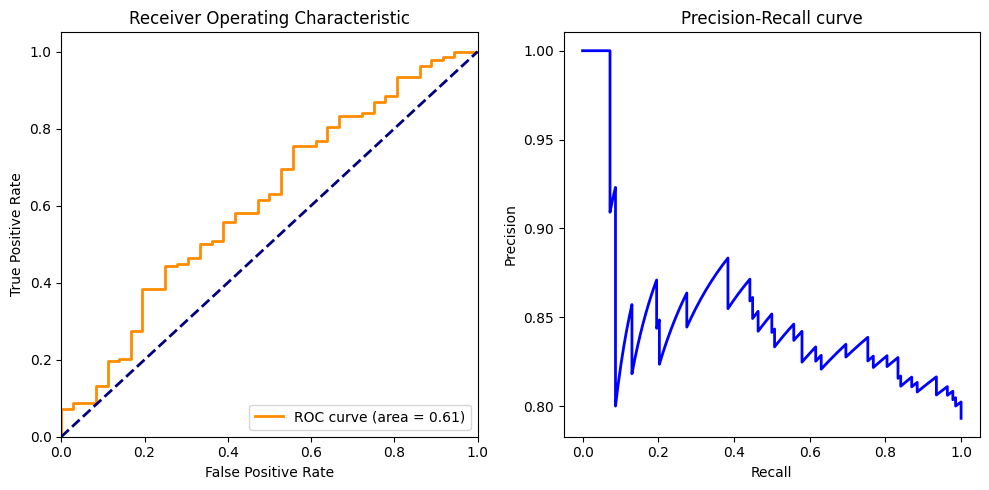

In [2]:
# Imports
import os
import re
import random
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display, HTML
from sklearn.model_selection import StratifiedKFold

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# TensorBoard writer
writer = SummaryWriter()

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 230)

# Seed settings
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed_all(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Directory and file paths
raw_image_path = '/content/US_Pictures/US_Pictures/'
image_path = '/content/US_Pictures/US_Pictures/Preprocessed/'
zip_path = '/content/US_Pictures.zip'
data_url = "https://raw.githubusercontent.com/Dicti93/MLSEM/master/2.%20Data%20and%20Description/data.csv"
model_path = 'model.pth'

# Hyperparameters and constants
learning_rate = 0.0001
num_epochs = 10
batch_size = 16
early_stopping_patience = 5

# Ensure the required directories exist
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        logger.info(f"Directory created: {path}")
        print(f"Directory created: {path}")

ensure_directory_exists(raw_image_path)
ensure_directory_exists(image_path)

# Download and extract data if necessary
def download_and_extract_data():
    if not os.listdir(raw_image_path) or not any(f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')) for f in os.listdir(raw_image_path)):
        logger.info("Downloading data...")
        print("Downloading data...")
        os.system(f'wget -O {zip_path} https://zenodo.org/records/7669442/files/US_Pictures.zip')
        os.system(f'unzip -q {zip_path} -d /content/US_Pictures/')
    else:
        logger.info("Data already downloaded.")
        print("Data already downloaded.")

download_and_extract_data()

# Display first five images
def display_images(image_path, num_images=10):
    files = [f for f in os.listdir(image_path) if f.endswith(('.png', '.bmp'))][:num_images]
    if not files:
        logger.warning("No image files found in the directory.")
        print("No image files found in the directory.")
        return
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, file in enumerate(files):
        img = Image.open(os.path.join(image_path, file))
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(file)
    plt.show()

display_images(raw_image_path)

# Load and preprocess dataset
def load_and_preprocess_data(data_url):
    print("Loading and preprocessing data...")
    data = pd.read_csv(data_url, delimiter=';')
    columns_to_drop = [
        'Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Management', 'Severity',
        'Diagnosis_Presumptive', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US',
        'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness',
        'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage',
        'Segmented_Neutrophils', 'Neutrophilia', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
        'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool', 'Peritonitis',
        'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers',
        'Target_Sign', 'Appendicolith', 'Perfusion', 'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
        'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location', 'Bowel_Wall_Thickening',
        'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism', 'Enteritis', 'Gynecological_Findings'
    ] + [f'Unnamed: {i}' for i in range(58, 69)]
    data.drop(columns=columns_to_drop, inplace=True)
    data['Diagnosis'].replace({'appendicitis': 1, 'no appendicitis': 0, np.nan: 0}, inplace=True)
    data.dropna(subset=['US_Number'], inplace=True)
    data['US_Number'] = data['US_Number'].astype(int)
    data['Diagnosis'] = data['Diagnosis'].astype(int)
    id_to_label = {int(row['US_Number']): row['Diagnosis'] for index, row in data.iterrows()}
    print(f"Loaded and preprocessed data with {len(id_to_label)} entries")
    return id_to_label

id_to_label = load_and_preprocess_data(data_url)
logger.info(f"Loaded and preprocessed data with {len(id_to_label)} entries")

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7105, 0.7467, 0.3402], std=[0.2721, 0.3070, 0.2304])
])

# Process and save images
def process_and_save_images(root_dir, output_dir, transform):
    ensure_directory_exists(output_dir)
    print("Processing and saving images...")
    for filename in tqdm(os.listdir(root_dir), desc="Processing images"):
        file_path = os.path.join(root_dir, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                with Image.open(file_path).convert('RGB') as img:
                    transformed_tensor = transform(img)
                    transformed_img = TF.to_pil_image(transformed_tensor)
                    output_file_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.png')
                    transformed_img.save(output_file_path, format='PNG')
            except Exception as e:
                logger.error(f"Failed to process {filename}: {str(e)}")
                print(f"Failed to process {filename}: {str(e)}")

process_and_save_images(raw_image_path, image_path, transform)

display_images(image_path)

# Dataset class for single images
class MedicalImagesDataset(Dataset):
    def __init__(self, root_dir, labels_dict, transform=None, augment=False):
        self.root_dir = root_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.augment = augment
        self.image_files = []
        self.labels = []

        print("Initializing MedicalImagesDataset...")
        for filename in os.listdir(root_dir):
            base_name = filename.split(' ')[0]
            match = re.match(r"([0-9]+(?:\.[0-9]+)?)", base_name)
            if match:
                image_number = int(match.group(1).split('.')[0])
                label = labels_dict.get(image_number)
                if label is not None:
                    self.image_files.append(filename)
                    self.labels.append(label)

        print(f"Initialized MedicalImagesDataset with {len(self.image_files)} images.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

dataset = MedicalImagesDataset(image_path, id_to_label, transform)
logger.info(f"Dataset initialized with {len(dataset)} samples")
print(f"Dataset initialized with {len(dataset)} samples")

# Data loaders
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes before training
logger.info(f"Training set size: {len(train_loader.dataset)}")
logger.info(f"Validation set size: {len(val_loader.dataset)}")
logger.info(f"Test set size: {len(test_loader.dataset)}")
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation process with Early Stopping
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, model_path, patience):
    best_val_roc_auc = 0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            optimizer.zero_grad()
            outputs = model(images)
            labels = labels.float().view(-1, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(outputs.detach().cpu().numpy())
            train_labels.extend(labels.detach().cpu().numpy())

        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_labels, (np.array(train_preds) > 0.5).astype(int))
        train_roc_auc = roc_auc_score(train_labels, train_preds)

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('ROC_AUC/train', train_roc_auc, epoch)

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                outputs = model(images)
                val_preds.extend(outputs.detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())

        val_acc = accuracy_score(val_labels, (np.array(val_preds) > 0.5).astype(int))
        val_roc_auc = roc_auc_score(val_labels, val_preds)

        writer.add_scalar('Accuracy/val', val_acc, epoch)
        writer.add_scalar('ROC_AUC/val', val_roc_auc, epoch)

        logger.info(f"Epoch {epoch+1}/{num_epochs}")
        logger.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train ROC AUC: {train_roc_auc:.4f}")
        logger.info(f"Val Acc: {val_acc:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train ROC AUC: {train_roc_auc:.4f}")
        print(f"Val Acc: {val_acc:.4f}, Val ROC AUC: {val_roc_auc:.4f}")

        # Save the model checkpoint if validation ROC AUC improves
        if val_roc_auc > best_val_roc_auc:
            best_val_roc_auc = val_roc_auc
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'train_roc_auc': train_roc_auc,
                'val_acc': val_acc,
                'val_roc_auc': val_roc_auc,
            }, model_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            logger.info("Early stopping triggered")
            print("Early stopping triggered")
            break

train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, model_path, early_stopping_patience)

# Test the model on the test dataset
def test_model(model, test_loader):
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            outputs = model(images)
            test_preds.extend(outputs.detach().cpu().numpy())
            test_labels.extend(labels.detach().cpu().numpy())

    test_acc = accuracy_score(test_labels, (np.array(test_preds) > 0.5).astype(int))
    test_roc_auc = roc_auc_score(test_labels, test_preds)
    logger.info(f"Test Acc: {test_acc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")
    print(f"Test Acc: {test_acc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

test_model(model, test_loader)

# Load the model
def load_model(model_path):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    train_acc = checkpoint['train_acc']
    train_roc_auc = checkpoint['train_roc_auc']
    val_acc = checkpoint['val_acc']
    val_roc_auc = checkpoint['val_roc_auc']
    model.eval()
    return epoch, train_loss, train_acc, train_roc_auc, val_acc, val_roc_auc

epoch, train_loss, train_acc, train_roc_auc, val_acc, val_roc_auc = load_model(model_path)

# Plot ROC and Precision-Recall curves
def plot_roc_and_recall(model, test_loader):
    model.eval()
    test_preds, test_labels = [], []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0], data[1]
            outputs = model(images)
            test_preds.extend(outputs.detach().cpu().numpy())
            test_labels.extend(labels.detach().cpu().numpy())

    # ROC Curve
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = roc_auc_score(test_labels, test_preds)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(test_labels, test_preds)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')

    plt.tight_layout()
    plt.show()

plot_roc_and_recall(model, test_loader)

# Close TensorBoard writer
writer.close()
